In [14]:
import requests 
import pandas as pd
import re
import urllib.parse
import matplotlib.pyplot as plt
import numpy as np

Получим датасет

In [60]:
pd.read_csv("ffkkmo_2021_dump.csv").merge(pd.read_csv("ffkkmo_2122_dump.csv"))

,Unnamed: 0,date,place,online,category,segment,rank,firstname,middlename,lastname,club,tss,tes,pcs


In [64]:
df = pd.concat(map(lambda x : pd.read_csv(f"ffkkmo_{x}_dump.csv"), ['2021', '2122', '2223', '2324', '2425'])).reset_index()

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33358 entries, 0 to 33357
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       33358 non-null  int64  
 1   Unnamed: 0  33358 non-null  int64  
 2   date        33358 non-null  object 
 3   place       33358 non-null  object 
 4   online      33358 non-null  object 
 5   category    33358 non-null  object 
 6   segment     33358 non-null  object 
 7   rank        33358 non-null  int64  
 8   firstname   33358 non-null  object 
 9   middlename  952 non-null    object 
 10  lastname    33358 non-null  object 
 11  club        33358 non-null  object 
 12  tss         33358 non-null  float64
 13  tes         33358 non-null  float64
 14  pcs         33358 non-null  float64
dtypes: float64(3), int64(3), object(9)
memory usage: 4.1+ MB


In [66]:
# Удалим строки без результата
df = df.drop(df[df['rank'].isin(['WD', 'FNR', 'DSQ', '0'])].index)

In [68]:
# Приведем типы данных
df['date'] = df['date'].str.strip()
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [69]:
# Добавим год
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['season'] = df['date'].apply(lambda x: f"{x.year-2001}{x.year-2000}" if x.month < 8 else f"{x.year-2000}{x.year-1999}")

In [70]:
def replace_duplicates(df, keyword, name, field='club'):
    uniquenames = [ s for s in df[field].unique() if keyword.findall(str(s).lower()) ]
    return df[field].replace(uniquenames, name)

In [71]:
def get_regex_cat(num, cat, gender):
    return re.compile((r"(" + num + ")(?s:.*?)(" + cat + ")(?s:.*?)(" + gender + ")").lower())

In [72]:
def get_regex_club(city, club):
    return re.compile((r"(" + club + ")(?s:.*?)(" + city + ")|(" + city + ")(?s:.*?)(" + club + ")").lower())

In [109]:
block_clubs = ['Белгородская область, МБУДО ДЮСШ по ЗВС',
 'Брянская область, СШ по ФКК ГАУ СК "Брянск"',
 'В\\К',
 'Владимирская область, МАУ СШ "Мотодром Арена"',
 'Владимирская область, МБУ СШОР г. Муром',
 'Воронежская область, ДЮСШ "Восточная" г. Лиски',
 'Воронежская область, ДЮСШ ФК "Хрустальный конёк"',
 'Воронежская область, МБУ СШОР №24',
 'ИП В. Азроян',
 'Калужская область, МБУ СШ "Космос" г. Калуга',
 'Костромская область, СШОР им. А.В. Голубева',
 'Курская область, АУ КО "Школа ЗВС "Арена"',
 'МБУ ДО БГО «СШОР»',
 'ООО «ХРУСТАЛЬНЫЙ ЛЁД»',
 'ООО «ХРУСТАЛЬНЫЙ ЛЕД»',
 'Рязанская область, ГАУ РО "СШ ДС "Олимпийский"',
 'Тверская область, ГБУ СШОР по ЛВС г. Тверь',
 'Тверская область, СШ ФФК г. Тверь',
 'Тульская область, ОКСШОР г. Тула',
 'Школа ФК Натальи Бестемьяновой',
 'Ярославская область, МУ СШОР №4',
 'Воронежская область, ДЮСШ ФК "Хрустальный конек"']

In [110]:
df.drop(df[df.club.isin(block_clubs)].index, inplace = True)

In [107]:
[ s for s in df.club.unique() if get_regex_club('Надежды', '').findall(str(s).lower()) ]

['г.о. Красногорск, АНО ДО АФК «Наши Надежды»']

In [76]:
df['club'] = replace_duplicates(df, get_regex_club('', 'Ляпкина'), 'г.о. Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»')
df['club'] = replace_duplicates(df, get_regex_club('', 'Ляпкна'), 'г.о. Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»')
df['club'] = replace_duplicates(df, get_regex_club('', 'Голден'), 'г.о. Балашиха, СКФК «Голден Стар»')
df['club'] = replace_duplicates(df, get_regex_club('Балашиха', 'Олимп'), "г.о. Балашиха, АНО ДЮСШ «Олимп»")
df['club'] = replace_duplicates(df, get_regex_club('Мытищи', 'Авангард'), 'г.о. Мытищи, МБУ ДО «СШ «Авангард»')
df['club'] = replace_duplicates(df, get_regex_club('МБУ', 'Авангард'), 'г.о. Мытищи, МБУ ДО «СШ «Авангард»')
df['club'] = replace_duplicates(df, get_regex_club('Королев', 'Варяг'), 'г. Королев, СК «Варяг»')
df['club'] = replace_duplicates(df, get_regex_club('Королёв', 'Варяг'), 'г. Королев, СК «Варяг»')
df['club'] = replace_duplicates(df, get_regex_club('', 'Спортивные учреждения'), 'г. Королев, МБУ «Спортивные Сооружения»')
df['club'] = replace_duplicates(df, get_regex_club('', 'Спортивные Сооружения'), 'г. Королев, МБУ «Спортивные Сооружения»')
df['club'] = replace_duplicates(df, get_regex_club('', 'Наши Надежды'), 'г.о. Красногорск, АНО ДО АФК «Наши Надежды»')
df['club'] = replace_duplicates(df, get_regex_club('', 'пахом'), 'г.о. Химки, АНО ДО «СШФК памяти Л.А. Пахомовой»')
df['club'] = replace_duplicates(df, get_regex_club('Наро-Фоминск', 'СШ'), 'г.о. Наро-Фоминский, МАУ ДО ЦСШ №1')
df['club'] = replace_duplicates(df, get_regex_club('Фоминск', 'МАУ'), 'г.о. Наро-Фоминский, МАУ ДО ЦСШ №1')
df['club'] = replace_duplicates(df, get_regex_club('Фомиск', 'МАУ'), 'г.о. Наро-Фоминский, МАУ ДО ЦСШ №1')
df['club'] = replace_duplicates(df, get_regex_club('Фомнск', 'МАУ'), 'г.о. Наро-Фоминский, МАУ ДО ЦСШ №1')
df['club'] = replace_duplicates(df, get_regex_club('Наро-Фоминск', 'Галактика'), 'г.о. Наро-Фоминск, ООО СКФК «Галактика»')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Давыдов'), 'г.о. Красногорск, ИП Давыдов')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'КСШОР'), 'г.о. Красногорск, МБУ КСШОР "Зоркий"')
df['club'] = replace_duplicates(df, get_regex_club('', 'Зоркий'), 'г.о. Красногорск, МБУ КСШОР "Зоркий"')
df['club'] = replace_duplicates(df, get_regex_club('', 'Снежком'), 'г.о. Красногорск, ЦФМ «Снежком»')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Снеж.ком'), 'г.о. Красногорск, ЦФМ «Снежком»')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'ЦФМ'), 'г.о. Красногорск, ЦФМ «Снежком»')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'DAVYDOV'), 'г.о. Красногорск, START TEAM DAVYDOV')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Козачинский'), 'г.о. Красногорск, ИП Козачинский')
df['club'] = replace_duplicates(df, get_regex_club('Красногоск', 'Козачинский'), 'г.о. Красногорск, ИП Козачинский')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Вербилло'), 'г.о. Красногорск, ИП Вербилло')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Вербило'), 'г.о. Красногорск, ИП Вербилло')
df['club'] = replace_duplicates(df, get_regex_club('', 'Путь к успеху'), 'г.о. Красногорск, Союз МС Школа «Путь к успеху»')
df['club'] = replace_duplicates(df, get_regex_club('Красногорск', 'Эдвайс'), 'г.о. Красногорск, «ООО НК Эдвайс»')
df['club'] = replace_duplicates(df, get_regex_club('Люберцы', 'КСШОР'), 'г.о. Люберцы, МУДО КСШОР')
df['club'] = replace_duplicates(df, get_regex_club('Луберцы', ''), 'г.о. Люберцы, МУДО КСШОР')
df['club'] = replace_duplicates(df, get_regex_club('', 'Армия'), "г.о. Люберцы, СК «Армия фигурного катания»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Армия фигурного катания'), "г.о. Люберцы, СК «Армия фигурного катания»")
df['club'] = replace_duplicates(df, get_regex_club('Лыткарино', ''), "г.о. Лыткарино, МАУ «ЛСК Лыткарино»")
df['club'] = replace_duplicates(df, get_regex_club('Ступино', 'Боброва'), "г. Ступино, МБУ ДО «СШОР им. В.Б. Боброва»")
df['club'] = replace_duplicates(df, get_regex_club('Щелково', ''), "г.о. Щелково, МАУ ГОЩ «ФОК «Ледовая арена» им. В.А. Третьяка")
df['club'] = replace_duplicates(df, get_regex_club('Щёлково', ''), "г.о. Щелково, МАУ ГОЩ «ФОК «Ледовая арена» им. В.А. Третьяка")
df['club'] = replace_duplicates(df, get_regex_club('Третьяка', ''), "г.о. Щелково, МАУ ГОЩ «ФОК «Ледовая арена» им. В.А. Третьяка")
df['club'] = replace_duplicates(df, get_regex_club('Щелкого', ''), "г.о. Щелково, МАУ ГОЩ «ФОК «Ледовая арена» им. В.А. Третьяка")
df['club'] = replace_duplicates(df, get_regex_club('Подольск', 'Витязь'), "г.о. Подольск, МУ ДО СШОР «Витязь»")
df['club'] = replace_duplicates(df, get_regex_club('Подольск', 'Арена'), "г.о. Подольск, ШФК «Арена»")
df['club'] = replace_duplicates(df, get_regex_club('Подольск', 'Слуцкой'), "г.о. Подольск, ШФК Слуцкой")
df['club'] = replace_duplicates(df, get_regex_club('Чехов', 'Витязь'), "г.о. Чехов, МАУ «СШ «Витязь» им. В.И. Васильева")
df['club'] = replace_duplicates(df, get_regex_club('Васильева', 'Витязь'), "г.о. Чехов, МАУ «СШ «Витязь» им. В.И. Васильева")
df['club'] = replace_duplicates(df, get_regex_club('Чехов', 'Спарта'), "г.о. Чехов, МАУ «СШ «Спарта»")
df['club'] = replace_duplicates(df, get_regex_club('', 'СЛУ-ГРУПП'), "г.о. Подольск, ООО «СЛУ-ГРУПП»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Заречье'), "п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой")
df['club'] = replace_duplicates(df, get_regex_club('ДЮСШ', 'Слуцкой'), "п. Заречье, ДЮСШ фигурного катания Ирины Слуцкой")
df['club'] = replace_duplicates(df, get_regex_club('', 'Лидер'), "г.о. Ивантеевка, МАУ ДО «СШ «Лидер»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Салют'), "г.о. Долгопрудный, АУ «ФСК-Салют»")
df['club'] = replace_duplicates(df, get_regex_club('', 'альфа'), "г.о. Долгопрудный, СК «Альфа»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Смирнова'), "г.о. Долгопрудный, АНО ДО СШФК «Смирнова Тим»")
df['club'] = replace_duplicates(df, get_regex_club('Клин', ''), "г. Клин, МБУ ДО СШОР «Клин спортивный»")
df['club'] = replace_duplicates(df, get_regex_club('Реутов', ''), "г.о. Реутов, Центр хоккея и фигурного катания «Айс Про»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Айс Про'), "г.о. Реутов, Центр хоккея и фигурного катания «Айс Про»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Ангелы'), "г.о. Одинцово, ООО «АФК «Ангелы Плющенко»")
df['club'] = replace_duplicates(df, get_regex_club('Одинцово', 'СШ'), "г.о. Одинцово, МБУ ДО СШ «Одинцово»")
df['club'] = replace_duplicates(df, get_regex_club('Одинцово', 'МБУС'), "г.о. Одинцово, МБУ ДО СШ «Одинцово»")
df['club'] = replace_duplicates(df, get_regex_club('Лобня', 'ЦФК'), "г.о. Лобня, МБУ «ЦФКиС»")
df['club'] = replace_duplicates(df, get_regex_club('Лобня', 'Дети'), "г.о. Лобня, СК ФК «Дети – наше будущее»")
df['club'] = replace_duplicates(df, get_regex_club('Дети', 'будущее'), "г.о. Лобня, СК ФК «Дети – наше будущее»")
df['club'] = replace_duplicates(df, get_regex_club('Лобня', 'Центр'), "г.о. Лобня, МБУ «ЦФКиС»")
df['club'] = replace_duplicates(df, get_regex_club('Лобня', 'УФК'), "г.о. Лобня, МБУ «ЦФКиС»")
df['club'] = replace_duplicates(df, get_regex_club('г.Лобня', ''), "г.о. Лобня, МБУ «ЦФКиС»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Арктика'), 'г.о. Ленинский, АНО «ЦОСБЛ и ТК»')
df['club'] = replace_duplicates(df, get_regex_club('Видное', 'Центр'), "г.о. Ленинский, ООО «Центр спортивных технологий»")
df['club'] = replace_duplicates(df, get_regex_club('Видное', 'ЦСТ'), "г.о. Ленинский, ООО «Центр спортивных технологий»")
df['club'] = replace_duplicates(df, get_regex_club('Ленинский', 'ЦСТ'), "г.о. Ленинский, ООО «Центр спортивных технологий»")
df['club'] = replace_duplicates(df, get_regex_club('Ленинский', 'Центр'), "г.о. Ленинский, ООО «Центр спортивных технологий»")
df['club'] = replace_duplicates(df, get_regex_club('Видное', 'ЦОСБЛ'), "г.о. Ленинский, АНО «ЦОСБЛ и ТК»")
df['club'] = replace_duplicates(df, get_regex_club('Ленинский', 'ЦОСБЛ'), "г.о. Ленинский, АНО «ЦОСБЛ и ТК»")
df['club'] = replace_duplicates(df, get_regex_club('Можайск', ''), "г.о. Можайск, МУ «МДС «Багратион»")
df['club'] = replace_duplicates(df, get_regex_club('Электросталь', 'Стальной'), "г. Электросталь, СКФК «Стальной конек»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Стальной конек'), "г. Электросталь, СКФК «Стальной конек»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Кристалл'), "г. Электросталь, МБУДО «СШОР «Кристалл-Восток»")
df['club'] = replace_duplicates(df, get_regex_club('', 'ВОСТОК'), "г. Электросталь, МБУДО «СШОР «Кристалл-Восток»")
df['club'] = replace_duplicates(df, get_regex_club('Электросталь', 'ангел'), "г. Электросталь, ООО «КФК «Ледяной ангел»")
df['club'] = replace_duplicates(df, get_regex_club('Электросталь', 'Мартынова'), "г. Электросталь, ИП Мартынова")
df['club'] = replace_duplicates(df, get_regex_club('Селятино', 'Юность'), "п. Селятино, МАУ СШ №2 «Юность»")
df['club'] = replace_duplicates(df, get_regex_club('Раменское', ''), "г.о. Раменское, МБУ ДО «СШ «Раменское»")
df['club'] = replace_duplicates(df, get_regex_club('Люберцы', 'ХРУСТАЛЬНЫЙ'), "г.о. Люберцы, ООО «Хрустальный лёд»")
df['club'] = replace_duplicates(df, get_regex_club('Серги', 'Центр'), "г.о. Сергиев Посад, МБУ ДО СШ «Центр»")
df['club'] = replace_duplicates(df, get_regex_club('МБУ', '«Центр»'), "г.о. Сергиев Посад, МБУ ДО СШ «Центр»")
df['club'] = replace_duplicates(df, get_regex_club('Серги', 'ХРУСТАЛЬНЫЙ ЛЁД'), "г.о. Сергиев Посад, ООО «Хрустальный лед»")
df['club'] = replace_duplicates(df, get_regex_club('Серги', 'ХРУСТАЛЬНЫЙ ЛеД'), "г.о. Сергиев Посад, ООО «Хрустальный лед»")
df['club'] = replace_duplicates(df, get_regex_club('Серги', 'Стремление'), "г.о. Сергиев Посад, ООО «Стремление»")
df['club'] = replace_duplicates(df, get_regex_club('Домодедово', 'Спицын'), "г.о. Домодедово, ИП Спицин")
df['club'] = replace_duplicates(df, get_regex_club('Домодедово', 'Спицин'), "г.о. Домодедово, ИП Спицин")
df['club'] = replace_duplicates(df, get_regex_club('Домодедово', 'Авангард'), "г.о. Домодедово, МАУ «ГС «Авангард»")
df['club'] = replace_duplicates(df, get_regex_club('Домодедово', 'Бестемьяновой'), "г.о. Домодедово, ШФК Натальи Бестемьяновой")
df['club'] = replace_duplicates(df, get_regex_club('Коломна', 'Комета'), "г.о. Коломна, МБУ ДО СШОР «Комета»")
df['club'] = replace_duplicates(df, get_regex_club('Жуковский', 'Метеор'), "г.о. Жуковский, МБУ ДО «СШ – Центр спорта «Метеор»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Демченко'), "г.о. Дмитровский, МУ ДО «СШОР Альберта Демченко»")
df['club'] = replace_duplicates(df, get_regex_club('Дмитров', 'Карпенко'), "г.о. Дмитровский, ИП Карпенко")
df['club'] = replace_duplicates(df, get_regex_club('Павлов', ''), "г.о. Павловский Посад, МУДО ДЮСШ")
df['club'] = replace_duplicates(df, get_regex_club('Серпухов', 'Спартак'), "г. Серпухов, МАУ Стадион «Спартак»")
df['club'] = replace_duplicates(df, get_regex_club('Серпухов', 'Золотой'), "г. Серпухов, СКФК «Золотой Конёк»")
df['club'] = replace_duplicates(df, get_regex_club('Серпухов', 'Благова'), "г. Серпухов, АНО АФК им. Василия Благова")
df['club'] = replace_duplicates(df, get_regex_club('Химки', 'ЗВС'), "г.о. Химки, МАУ ДО «СШ ЗВС»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Бородул'), "г.о. Химки, СКФК Бородулиных")
df['club'] = replace_duplicates(df, get_regex_club('Ногинск', ''), "г. Ногинск, МБУ «СШОР»")
df['club'] = replace_duplicates(df, get_regex_club('Шаховская', ''), "г.о. Шаховская, МАУ «Шаховской ДОК»")
df['club'] = replace_duplicates(df, get_regex_club('', 'Алмазный'), "г.о. Подольск, СЦ «Алмазный лед МО»")
df['club'] = replace_duplicates(df, get_regex_club('Малаховка', ''), "г.о. Люберцы, СК «МГАФК - Малаховка»")
df['club'] = replace_duplicates(df, get_regex_club('Орехово', ''), "г. Орехово-Зуево, МУДО «СШ «Спартак Орехово»")
df['club'] = replace_duplicates(df, get_regex_club('ГБПОУ', 'УОР'), 'г.о. Краснознаменск, ГБПОУ МО «УОР № 1»')
df['category'] = replace_duplicates(df, get_regex_cat("3", "юн", "м"), "3-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "3", "юн"), "3-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("3", "юн", "чк"), "3-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "3", "юн"), "3-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "юн", "м"), "2-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "2", "юн"), "2-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "юн", "чк"), "2-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "2", "юн"), "2-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "юн", "м"), "1-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "1", "юн"), "1-й юношеский разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "юн", "чк"), "1-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "1", "юн"), "1-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "юн", "шк"), "1-й юношеский разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("3", "вн", "м"), "3-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("3", "вн", "ю"), "3-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "3", "вн"), "3-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("ю", "3", "вн"), "3-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("3", "вн", "чк"), "3-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("3", "вн", "шк"), "3-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "3", "вн"), "3-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("шк", "3", "вн"), "3-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "вн", "м"), "2-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "вн", "ю"), "2-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "2", "вн"), "2-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("ю", "2", "вн"), "2-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "вн", "чк"), "2-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("2", "вн", "шк"), "2-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "2", "вн"), "2-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("шк", "2", "вн"), "2-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "вн", "м"), "1-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "вн", "ю"), "1-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("м", "1", "вн"), "1-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("ю", "1", "вн"), "1-й спортивный разряд, мальчики", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "вн", "чк"), "1-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("1", "вн", "шк"), "1-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("чк", "1", "вн"), "1-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("шк", "1", "вн"), "1-й спортивный разряд, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("Юны", "", "д"), "Юный фигурист, девочки", 'category')
df['category'] = replace_duplicates(df, get_regex_cat("Юны", "", "м"), "Юный фигурист, мальчики", 'category')

In [121]:
def removeprefix(ss):
    if ss.startswith("г.о. "):
        return ss[len("г.о. "):]
    if ss.startswith("г. "):
        return ss[len("г. "):]

In [124]:
df.club = df.club.apply(removeprefix)

In [127]:
sorted([x for x in df.club.unique() if x is not None])

['Балашиха, АНО ДЮСШ «Олимп»',
 'Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»',
 'Балашиха, СКФК «Голден Стар»',
 'Дмитровский, ИП Карпенко',
 'Дмитровский, МУ ДО «СШОР Альберта Демченко»',
 'Долгопрудный, АНО ДО СШФК «Смирнова Тим»',
 'Долгопрудный, АУ «ФСК-Салют»',
 'Долгопрудный, СК «Альфа»',
 'Домодедово, ИП Спицин',
 'Домодедово, МАУ «ГС «Авангард»',
 'Домодедово, ШФК Натальи Бестемьяновой',
 'Жуковский, МБУ ДО «СШ – Центр спорта «Метеор»',
 'Ивантеевка, МАУ ДО «СШ «Лидер»',
 'Ивантеевка, МБУ СШ Ивантеевка',
 'Клин, МБУ ДО СШОР «Клин спортивный»',
 'Коломна, МБУ ДО СШОР «Комета»',
 'Королев, МБУ "Спортивное Сооружение"',
 'Королев, МБУ "Спортивное сооружения"',
 'Королев, МБУ «Спортивные Сооружения»',
 'Королев, СК «Варяг»',
 'Красногорск, START TEAM DAVYDOV',
 'Красногорск, «ООО НК Эдвайс»',
 'Красногорск, АНО ДО АФК «Наши Надежды»',
 'Красногорск, ИП Вербилло',
 'Красногорск, ИП Давыдов',
 'Красногорск, ИП Козачинский',
 'Красногорск, МБУ КСШОР "Зоркий"',
 'Красногорск, Союз МС Школ

In [77]:
year = 2024

In [93]:
def get_top_df(df, qty):
    df1 = df['club'].value_counts()
    others = df1[qty:].sum()
    df1 = df1[:qty]
    df1['Остальные'] = others
    return df1

In [95]:
def pie_of_winners(year, rank, limit):
    get_top_df(df[(df['year'] == year) & (df['rank'] <= rank)], limit).plot.pie(
        autopct='%1.f%%', 
        legend=False,
        wedgeprops = {"edgecolor" : "white", 
                      'linewidth': 2,
                      'antialiased': True});
    plt.title(f'Доля победителей в {year} году', fontsize=16)
    plt.xlabel('', fontsize=18)
    plt.ylabel('', fontsize=18)

In [80]:
def participants_for_club_in_year(year, club, limit, plot=True, sort_col='title'):
    data = df[(df['year'] == year) & (df['club'] == club)].groupby('name').count().sort_values(
        by=sort_col, ascending=True).head(limit)['title']
    if plot:
        ax = data.plot(
            kind='bar', figsize=(20, 5), grid=True
        )
        major_ticks = np.arange(0, max(data) + 1, 1)
        ax.set_yticks(major_ticks)
        plt.title(club, fontsize=32)
        plt.xlabel('Спортсмен', fontsize=16)
        plt.ylabel(f'Количество участий в {year} году', fontsize=18)
        plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');
    else:
        return data

In [81]:
def participants_for_club_in_season(season, club, limit, plot=True, sort_col='title'):
    data = df[(df['season'] == season) & (df['club'] == club)].groupby('name').count().sort_values(
        by=sort_col, ascending=True).head(limit)['title']
    if plot:
        ax = data.plot(
            kind='bar', figsize=(20, 5), grid=True
        )
        major_ticks = np.arange(0, max(data) + 1, 1)
        ax.set_yticks(major_ticks)
        plt.title(club, fontsize=32)
        plt.xlabel('Спортсмен', fontsize=16)
        plt.ylabel(f'Количество участий в сезоне {season}', fontsize=18)
        plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');
    else:
        return data

In [82]:
def plot_clubs_in_year(year, limit):
    df[df['year'] == year].groupby('club').count().sort_values(by='date', ascending=False)['date'].head(limit).plot(
        kind='bar', figsize=(20, 5), grid=True
    )
    plt.title(f'Распределение количества участий школ в {year} году', fontsize=32)
    plt.xlabel('Школа', fontsize=18)
    plt.ylabel('Количество участий', fontsize=18)
    plt.xticks(fontsize=20, rotation=70, horizontalalignment='right');

In [105]:
def sportsmens_of_clubs_in_year(year, limit, plot=True):
    tg_df = df[df['year'] == year].groupby(['club', 'firstname', 'lastname']).count().groupby('club').count().sort_values(
        by='date', ascending=False)['date'].head(limit)
    if plot:
        tg_df.plot(
            kind='bar', figsize=(25, 8), grid=True
        )
        plt.title(f'Количество спортсменов, участвовавших в официальных соревнованиях за {year} год', fontsize=32)
        plt.xlabel('Школа', fontsize=18)
        plt.ylabel('Количество спортсменов', fontsize=18)
        plt.xticks(fontsize=20, rotation=70, horizontalalignment='right');
    else:
        return tg_df

In [84]:
def winners_of_club(year, club):
    if type(year) == int:
        year_list = [year]
    else:
        year_list = year[:]
    return df[(df['year'].isin(year_list)) & (df['rank'] <= 3) & (df['club'] == club)]

In [85]:
def get_df_of_club_in_year(club, year):
    return df[(df['year'] == year) & (df['club'] == club)]

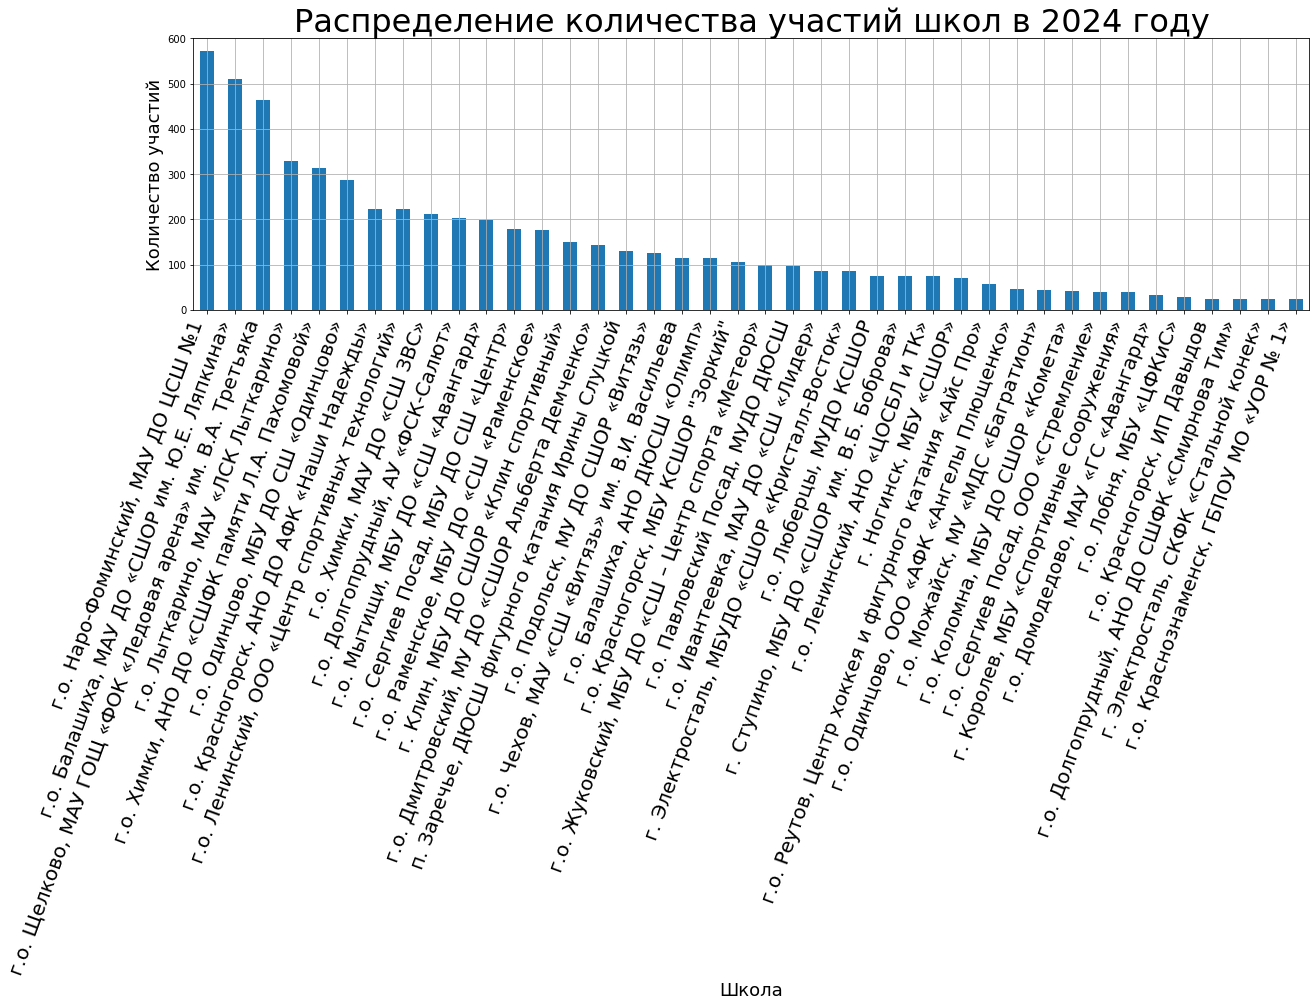

In [98]:
plot_clubs_in_year(2024, 40)

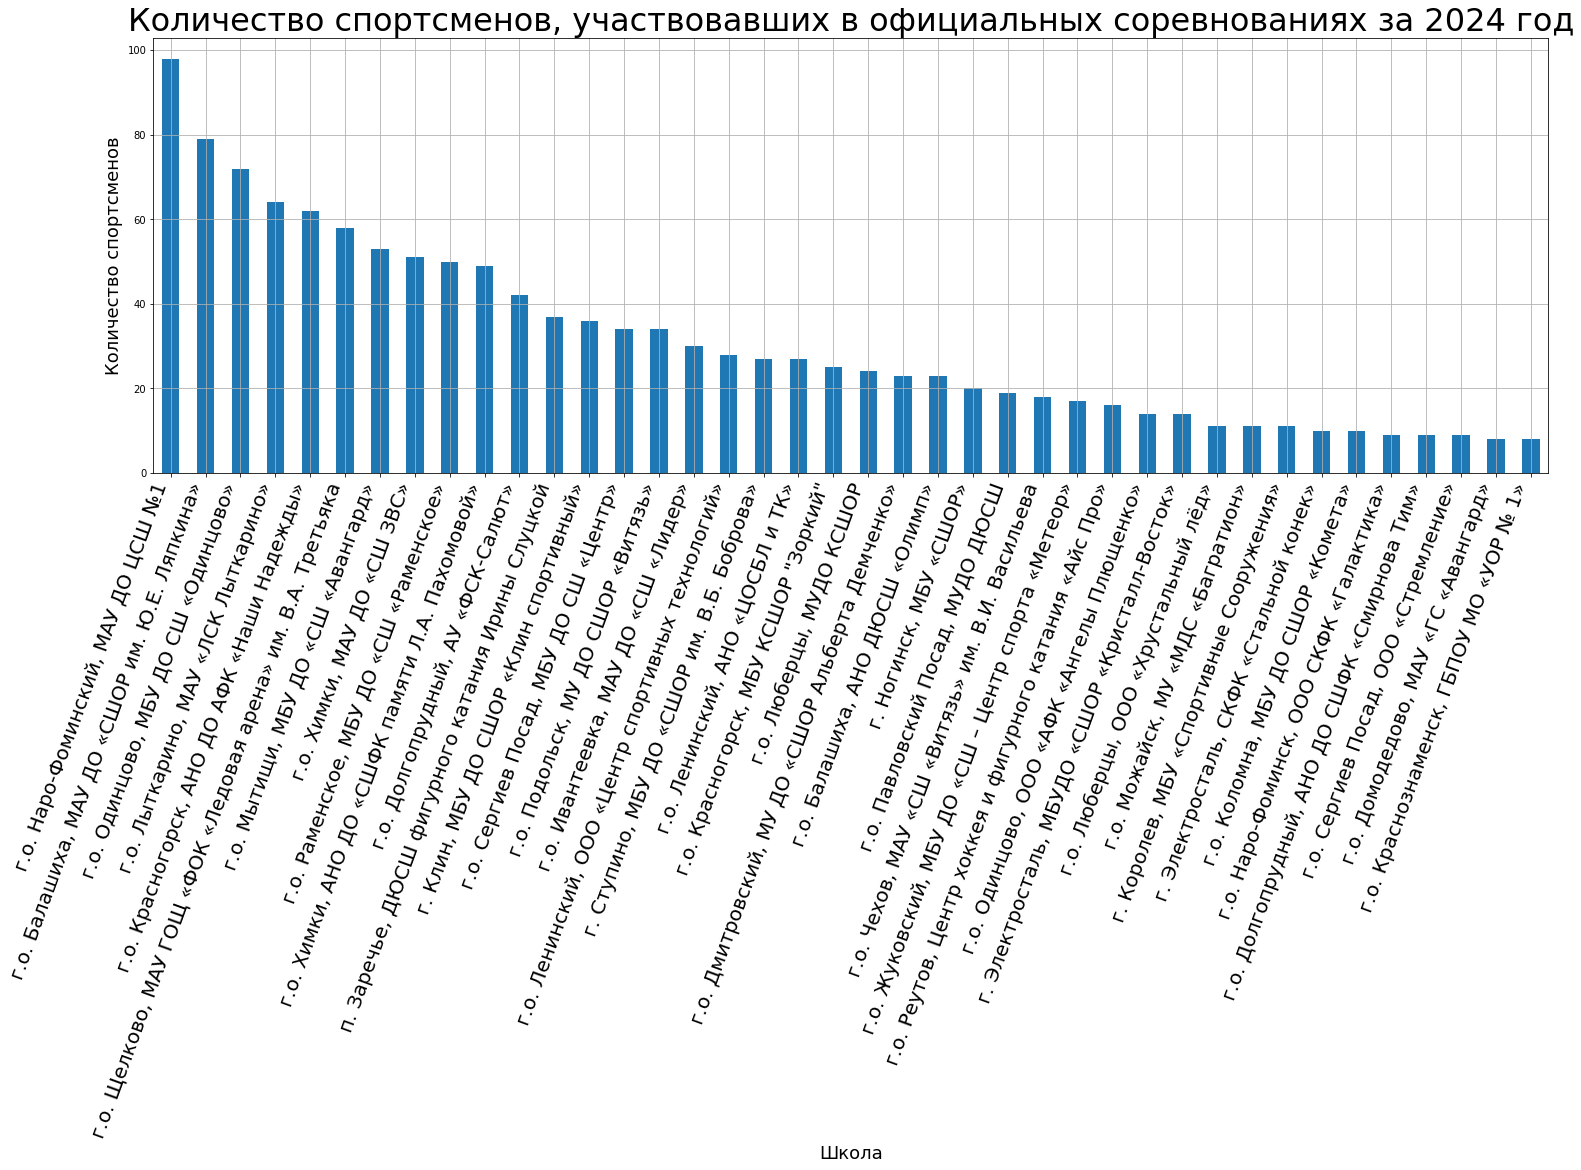

In [106]:
sportsmens_of_clubs_in_year(2024, 40, plot=True)

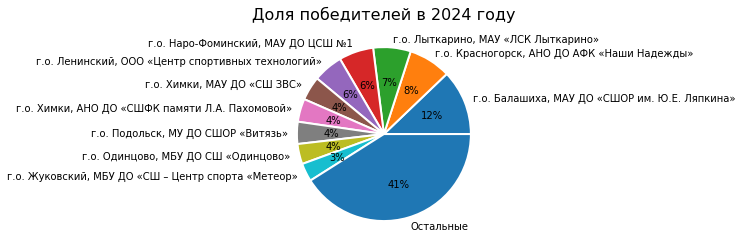

In [26]:
pie_of_winners(2024, 3, 10)

In [27]:
odn = "г.о. Одинцово, МБУ ДО СШ «Одинцово»"
mojaisk = "г.о. Можайск, МУ «МДС «Багратион»"
naro = 'г.о. Наро-Фоминский, МАУ ДО ЦСШ №1'
lyapkina = 'г.о. Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»'
galakt = 'г.о. Наро-Фоминск, ООО СКФК «Галактика»'
lybertsy = 'г.о. Люберцы, МУДО КСШОР'
klin = "г. Клин, МБУ ДО СШОР «Клин спортивный»"
stupino = "г. Ступино, МБУ ДО «СШОР им. В.Б. Боброва»"
lytkarino = "г.о. Лыткарино, МАУ «ЛСК Лыткарино»"
olimp = 'г.о. Балашиха, АНО ДЮСШ «Олимп»'
year = 2024

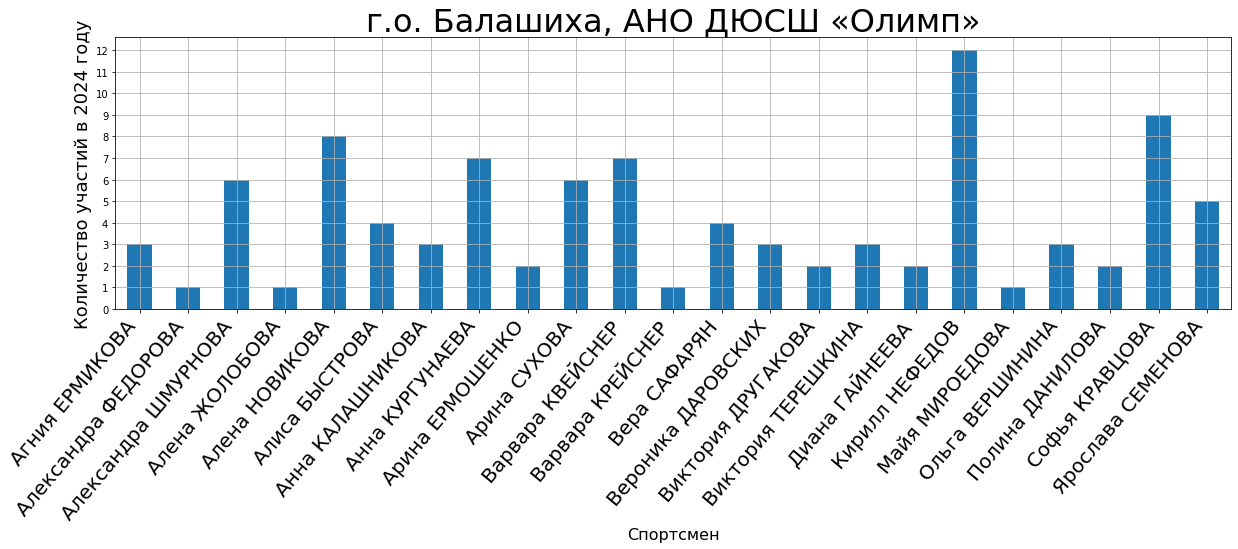

In [28]:
participants_for_club_in_year(2024, olimp, 80, sort_col='name')

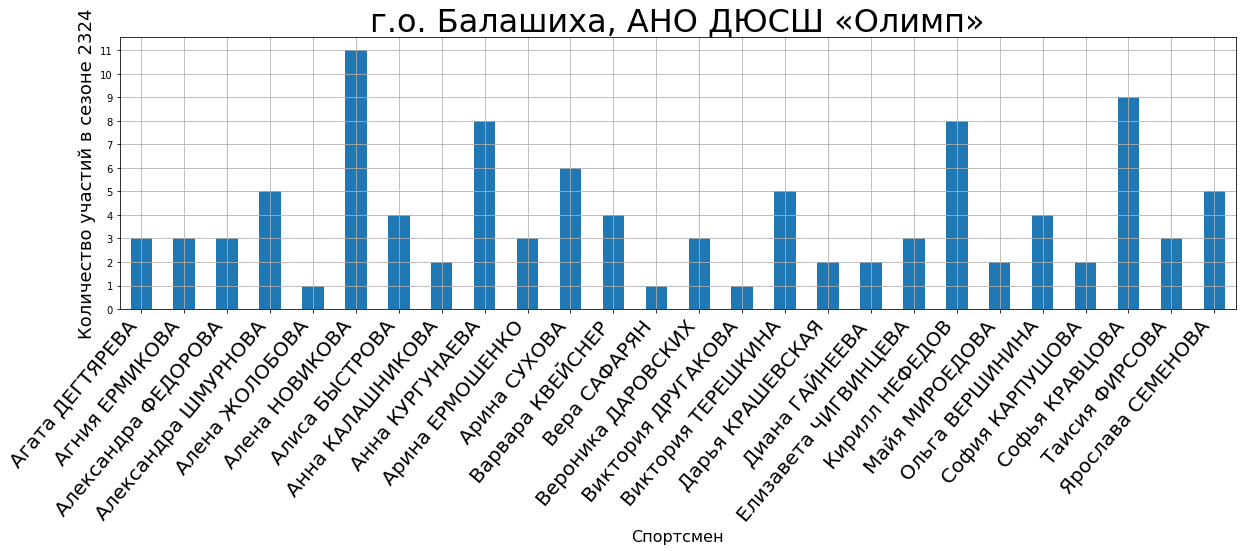

In [29]:
participants_for_club_in_season("2324", olimp, 80, sort_col='name')

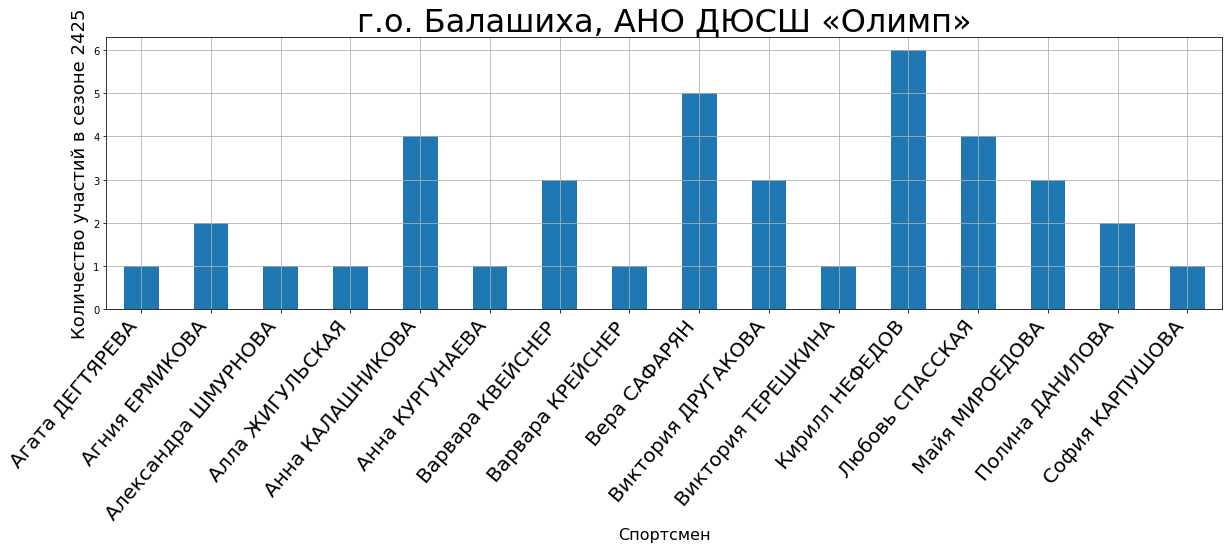

In [30]:
participants_for_club_in_season("2425", olimp, 80, sort_col='name')

In [31]:
get_df_of_club_in_year("г. Клин, МБУ ДО СШОР «Клин спортивный»", 2025).tail(30)

,Unnamed: 0,title,date,place,online_link,category,rank,name,club,points,year,month,season
24219,81,Спортивные соревнования Московской области по ...,2025-03-15,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin1503/CAT018RS...,"Юный фигурист, девочки",1,Анастасия ЯРОЩУК,"г. Клин, МБУ ДО СШОР «Клин спортивный»",11.84,2025,3,2425
24220,82,Спортивные соревнования Московской области по ...,2025-03-15,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin1503/CAT018RS...,"Юный фигурист, девочки",2,Николь РЕПИНА,"г. Клин, МБУ ДО СШОР «Клин спортивный»",10.94,2025,3,2425
24221,83,Спортивные соревнования Московской области по ...,2025-03-15,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin1503/CAT018RS...,"Юный фигурист, девочки",3,Алиса СААКЯН,"г. Клин, МБУ ДО СШОР «Клин спортивный»",10.91,2025,3,2425
24447,6,Спортивные соревнования Московской области по ...,2025-03-25,"г. Селятино, Спорткомбинат ""Строитель"" Ледовая...",http://ffkkmo.ru/events/2425/selyatino03/CAT00...,"Юный фигурист, девочки",7,Варвара КОЗЛОВА,"г. Клин, МБУ ДО СШОР «Клин спортивный»",9.96,2025,3,2425
24753,0,Спортивные соревнования Московской области по ...,2025-04-05,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin04/CAT002RS.HTM,"3-й юношеский разряд, девочки",1,Юмабика КИРГИЗБАЕВА,"г. Клин, МБУ ДО СШОР «Клин спортивный»",15.93,2025,4,2425
24754,1,Спортивные соревнования Московской области по ...,2025-04-05,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin04/CAT002RS.HTM,"3-й юношеский разряд, девочки",2,Дарья СЕВАСТЬЯНОВА,"г. Клин, МБУ ДО СШОР «Клин спортивный»",14.41,2025,4,2425
24755,2,Спортивные соревнования Московской области по ...,2025-04-05,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin04/CAT002RS.HTM,"3-й юношеский разряд, девочки",3,Алиса ШИБКО,"г. Клин, МБУ ДО СШОР «Клин спортивный»",14.18,2025,4,2425
24756,3,Спортивные соревнования Московской области по ...,2025-04-05,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin04/CAT002RS.HTM,"3-й юношеский разряд, девочки",4,Гаяне ШАХВЕРДЯН,"г. Клин, МБУ ДО СШОР «Клин спортивный»",14.02,2025,4,2425
24758,5,Спортивные соревнования Московской области по ...,2025-04-05,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin04/CAT002RS.HTM,"3-й юношеский разряд, девочки",6,Александра РУЗИНА,"г. Клин, МБУ ДО СШОР «Клин спортивный»",13.33,2025,4,2425
24759,6,Спортивные соревнования Московской области по ...,2025-04-05,"г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",http://ffkkmo.ru/events/2425/klin04/CAT002RS.HTM,"3-й юношеский разряд, девочки",7,Алина ТИХОМИРОВА,"г. Клин, МБУ ДО СШОР «Клин спортивный»",12.82,2025,4,2425


In [32]:
winners_of_club([2025], lytkarino).name.unique()

array(['Наталья СУХОВА', 'Илья МЕЛЬНИКОВ', 'Артемий ФРОЛОВ',
       'Таисия БЕРНАДСКАЯ', 'Алиса ВЕРХОВА', 'Александра КРУТОВА',
       'Стефания КОРОЛЬ', 'Екатерина АБРАМОВА', 'Андрей ШИЛИН',
       'Александр ИВАНИЧЕВ', 'Александра ЧУБАРА', 'Александра КЛИШИНА',
       'Арина СТРОГАНОВА', 'Полина КУРОВА', 'Полина СОЛОВЬЕВА',
       'Полина ДОЛГИХ', 'Александра ХАЛИКОВА', 'Виктория АФАНАСЬЕВА',
       'Милана ИЛЬИНА'], dtype=object)

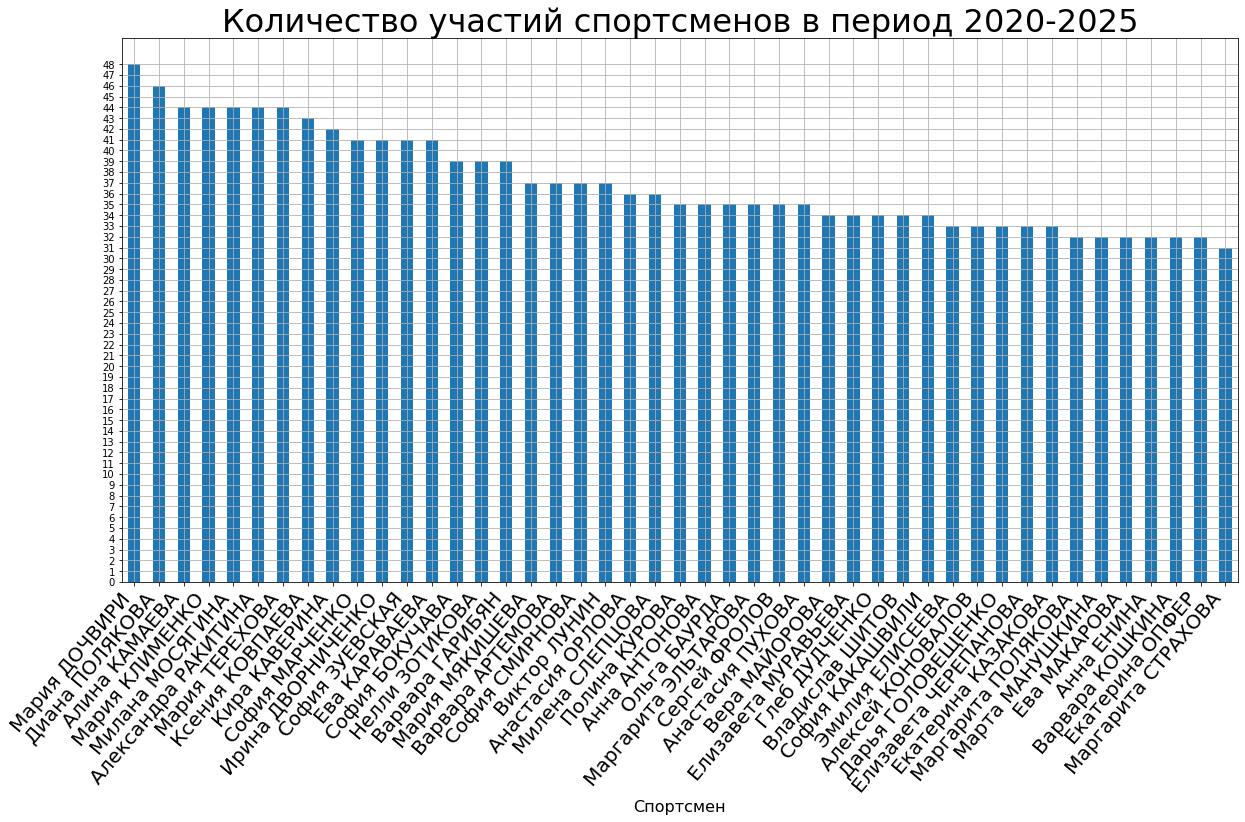

In [33]:
data = df.groupby('name').count().sort_values(
    by='title', ascending=False).head(45)['title']
ax = data.plot(
    kind='bar', figsize=(20, 10), grid=True
)
major_ticks = np.arange(0, max(data) + 1, 1)
ax.set_yticks(major_ticks)
plt.title("Количество участий спортсменов в период 2020-2025", fontsize=32)
plt.xlabel('Спортсмен', fontsize=16)
plt.ylabel(f'', fontsize=18)
plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');

In [34]:
df[df['name'] == 'Анастасия МАКСИМОВА']

,Unnamed: 0,title,date,place,online_link,category,rank,name,club,points,year,month,season
17630,15,Спортивные соревнования Московской области по ...,2023-11-06,"г. Химки, ул. Мичурина, стр. 24, к. 1, ФОК ""Но...",http://ffkkmo.ru/events/2324/himki11/CAT002RS.HTM,"3-й юношеский разряд, девочки",15,Анастасия МАКСИМОВА,"г.о. Химки, АНО ДО «СШФК памяти Л.А. Пахомовой»",3.73,2023,11,2324


In [35]:
category_names = ["3-й юношеский разряд, мальчики",
                "3-й юношеский разряд, девочки",
                "2-й юношеский разряд, мальчики",
                "2-й юношеский разряд, девочки",
                "1-й юношеский разряд, мальчики",
                "1-й юношеский разряд, девочки",
                "3-й спортивный разряд, мальчики",
                "3-й спортивный разряд, девочки",
                "2-й спортивный разряд, мальчики",
                "2-й спортивный разряд, девочки",
                "1-й спортивный разряд, мальчики",
                "1-й спортивный разряд, девочки",
                "Юный фигурист, девочки",
                "Юный фигурист, мальчики"]

In [36]:
df[df['category'].isin(category_names)&(df['year']==2024)].sort_values(by="points").groupby("category").last()[['place', 'date', 'name', 'points']]

,place,date,name,points
category,,,,
"1-й спортивный разряд, девочки","г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",2024-09-14,Альбина ГЕРАСИМОВА,164.76
"1-й спортивный разряд, мальчики","г.о. Клин, ул. Карла Маркса, д. 99, Ледовый дв...",2024-04-20,Дмитрий ПУСТОВАЛОВ,184.86
"1-й юношеский разряд, девочки","г. Ногинск, ул. Климова, д. 48, к. А, ФОК ""Лед...",2024-04-02,Ульяна РОЖКОВА,48.23
"1-й юношеский разряд, мальчики","г. Можайск, ул. Мира 15, ЛА ""Багратион""",2024-01-20,Артемий ФРОЛОВ,40.16
"2-й спортивный разряд, девочки","г. Ивантеевка, ул. Победы, д. 2, ФОК ЛСК ""Лидер""",2024-10-12,Елизавета НИКОЛАЕВА,134.13
"2-й спортивный разряд, мальчики","г. Клин, ул. Карла Маркса, д. 99, Ледовый двор...",2024-02-24,Максим СТИФУНИН,110.04
"2-й юношеский разряд, девочки","г. Щелково, ул. Фабричная, д. 4, Ледовая арена...",2024-03-19,Александра НЕЧАЕВА,33.30
"2-й юношеский разряд, мальчики","г. Наро-Фоминск, ул. Профсоюзная, д. 36Б, ледо...",2024-12-14,Александр КАНДИДОВ,30.17
"3-й спортивный разряд, девочки","г.о. Наро-Фоминск, г. Селятино, Спорткомбинат ...",2024-11-13,София СМИРНОВА,50.25


In [37]:
df[df['category'].isin(category_names)&(df['year']==2024)].groupby("category").count()['title']

category
1-й спортивный разряд, девочки     392
1-й спортивный разряд, мальчики     51
1-й юношеский разряд, девочки      489
1-й юношеский разряд, мальчики      36
2-й спортивный разряд, девочки     755
2-й спортивный разряд, мальчики     26
2-й юношеский разряд, девочки      747
2-й юношеский разряд, мальчики      51
3-й спортивный разряд, девочки     717
3-й спортивный разряд, мальчики     63
3-й юношеский разряд, девочки      632
3-й юношеский разряд, мальчики      39
Юный фигурист, девочки             280
Юный фигурист, мальчики             12
Name: title, dtype: int64

In [38]:
[ s for s in df['category'].unique() if get_regex_cat("", "ушк", "").findall(str(s).lower()) ]

['KMC, дeвушки',
 'MC, дeвушки',
 'Дeвушки',
 'Девушки, 3-й юношеский разряд',
 'KMC, девушки',
 'КМС, дeвушки',
 'МС, девушки',
 'КМС дeвушки',
 '2-й юношеский разряд, дeвушки',
 'KМС, девушки',
 '3 спopтиный рaзряд, девушки']

In [39]:
pivot_df = pd.pivot_table(df[df.month == 9], values='title', index='club', columns='season', aggfunc='count')

In [40]:
pivot_df.loc['г. Клин, МБУ ДО СШОР «Клин спортивный»']

season
2021     NaN
2122     NaN
2223     NaN
2324     NaN
2425    15.0
Name: г. Клин, МБУ ДО СШОР «Клин спортивный», dtype: float64

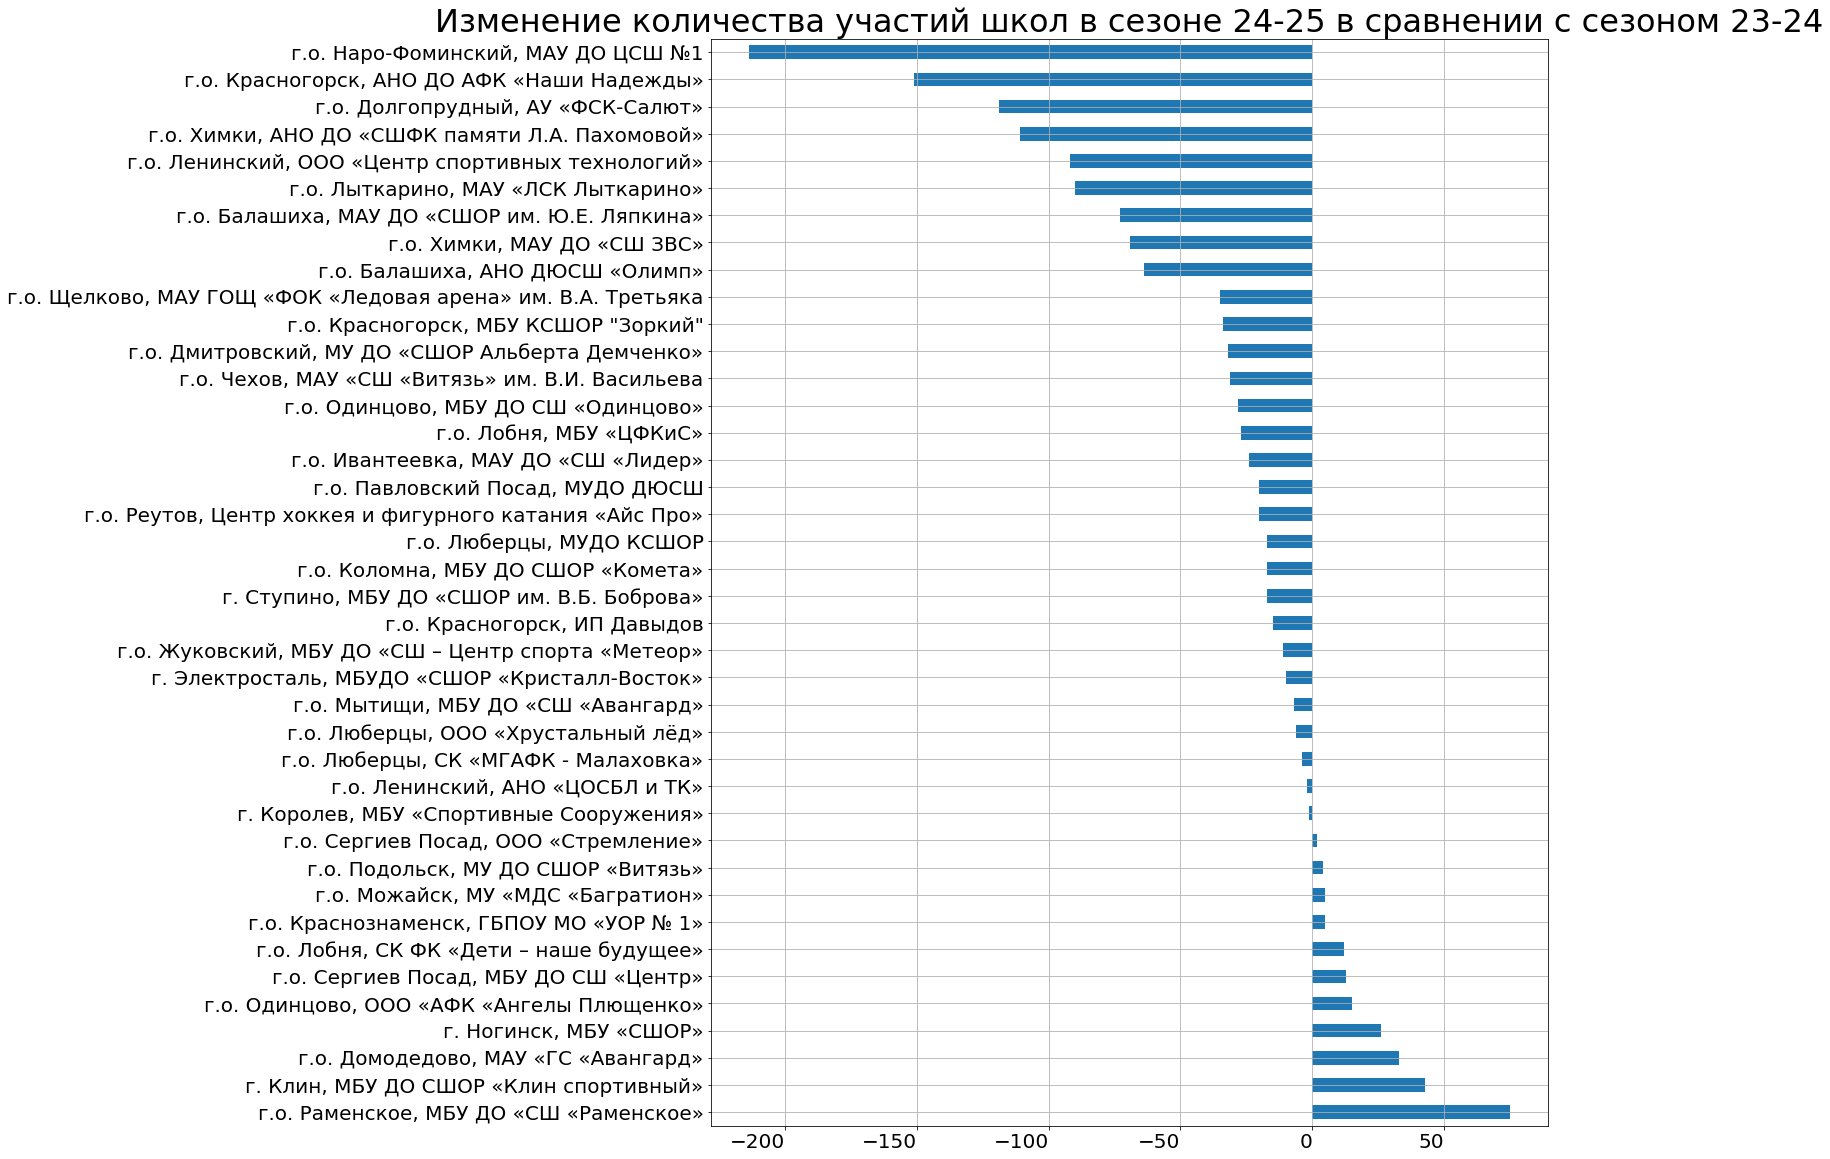

In [41]:
pivot_df = pd.pivot_table(df, values='title', index='club', columns='season', aggfunc='count')
tdf = pivot_df['2425'] - pivot_df['2324']
tdf = tdf.dropna()
tdf.sort_values(ascending=False).plot(
    kind='barh', figsize=(15, 20), grid=True
)
plt.title("Изменение количества участий школ в сезоне 24-25 в сравнении с сезоном 23-24", fontsize=32)
plt.ylabel(f'', fontsize=18)
plt.yticks(fontsize=20, rotation=0, horizontalalignment='right');
plt.xticks(fontsize=20, rotation=0, horizontalalignment='right');

In [42]:
pivot_df.dropna()

season,2021,2122,2223,2324,2425
club,,,,,
"г. Клин, МБУ ДО СШОР «Клин спортивный»",82.0,40.0,62.0,80.0,123.0
"г. Королев, МБУ «Спортивные Сооружения»",112.0,64.0,62.0,27.0,26.0
"г. Ногинск, МБУ «СШОР»",3.0,33.0,83.0,37.0,63.0
"г. Ступино, МБУ ДО «СШОР им. В.Б. Боброва»",83.0,80.0,64.0,59.0,42.0
"г. Электросталь, МБУДО «СШОР «Кристалл-Восток»",44.0,49.0,61.0,67.0,57.0
"г.о. Балашиха, АНО ДЮСШ «Олимп»",30.0,89.0,73.0,103.0,39.0
"г.о. Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",402.0,481.0,362.0,331.0,258.0
"г.о. Дмитровский, МУ ДО «СШОР Альберта Демченко»",113.0,177.0,133.0,120.0,88.0
"г.о. Долгопрудный, АУ «ФСК-Салют»",180.0,231.0,223.0,181.0,62.0


In [43]:
def sportsmens_qty_trend(season_prev, season_next, plot=True):
    pivot_df = pd.pivot_table(df, values='name', index='club', columns='season', aggfunc=lambda x: len(x.unique()))
    tdf = pivot_df[season_next] - pivot_df[season_prev]
    tdf = tdf.dropna()
    tdf = tdf.sort_values(ascending=False)
    if plot:
        tdf.plot(
            kind='barh', figsize=(15, 20), grid=True
        )
        plt.title("Изменение количества участий спортсменов в сезоне 24-25 в сравнении с сезоном 23-24", fontsize=32)
        plt.ylabel(f'', fontsize=18)
        plt.yticks(fontsize=20, rotation=0, horizontalalignment='right');
        plt.xticks(fontsize=20, rotation=0, horizontalalignment='right');
    else:
        return tdf

In [56]:
sportsmens_qty_trend("2324", "2425")

NameError: name 'sportsmens_qty_trend' is not defined

In [45]:
sportsmens_qty_trend("2324", "2425", plot=False).sum()

-210.0

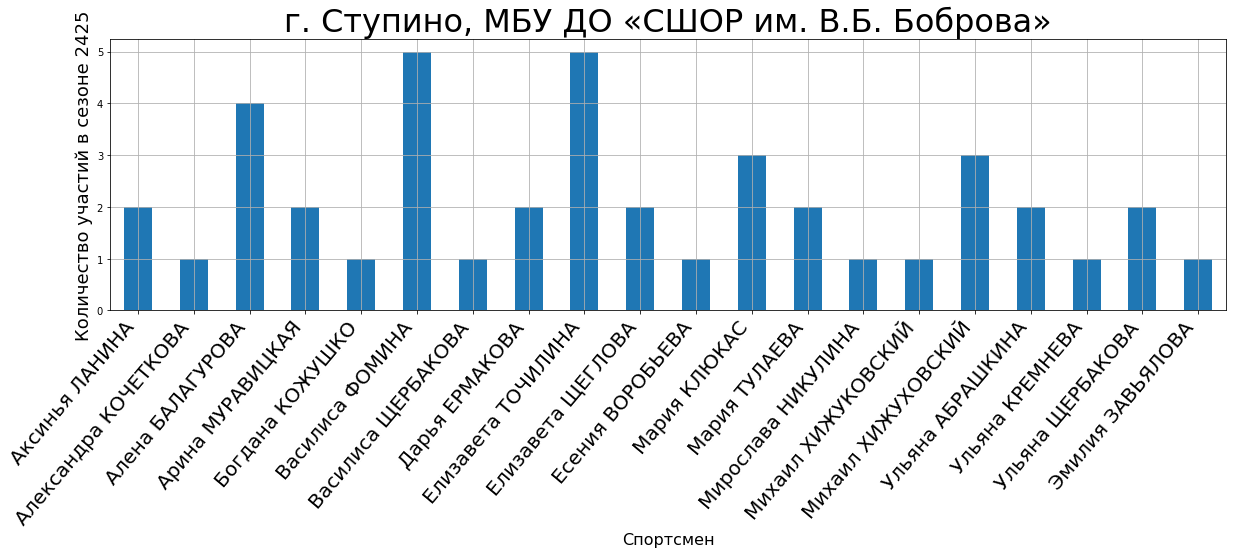

In [46]:
participants_for_club_in_season("2425", stupino, 100, sort_col='name')

In [47]:
pd.pivot_table(df[df.club==lytkarino], values='title', index='name', columns='season', aggfunc='count').to_csv("lytkarino_dump.csv")